In [4]:
!pip install diffusers
!pip install transformers 
!pip install torchvision
!pip install torch==2.1.0 
!pip install transformers  # Use Hugging Face's CLIP instead
!pip install opencv-python
!pip install matplotlib

  Using cached torch-2.1.0-cp310-cp310-manylinux1_x86_64.whl.metadata (25 kB)
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_nccl_cu12-2.18.1-py3-none-manylinux1_x86_64.whl.m

In [5]:
import torch
from transformers import CLIPProcessor, CLIPModel
from transformers import DetrImageProcessor, DetrForObjectDetection
import cv2
import numpy as np
from PIL import Image

# Load pretrained CLIP model and processor
clip_model = CLIPModel.from_pretrained("openai/clip-vit-base-patch32")
clip_processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")

# Load pretrained DETR model and processor
detr_model = DetrForObjectDetection.from_pretrained("facebook/detr-resnet-50")
detr_processor = DetrImageProcessor.from_pretrained("facebook/detr-resnet-50")

config.json:   0%|          | 0.00/4.19k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/605M [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/316 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/592 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/862k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/525k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.22M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/389 [00:00<?, ?B/s]

/opt/conda/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:1617: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


config.json:   0%|          | 0.00/4.59k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/167M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/102M [00:00<?, ?B/s]

Some weights of the model checkpoint at facebook/detr-resnet-50 were not used when initializing DetrForObjectDetection: ['model.backbone.conv_encoder.model.layer1.0.downsample.1.num_batches_tracked', 'model.backbone.conv_encoder.model.layer2.0.downsample.1.num_batches_tracked', 'model.backbone.conv_encoder.model.layer3.0.downsample.1.num_batches_tracked', 'model.backbone.conv_encoder.model.layer4.0.downsample.1.num_batches_tracked']
- This IS expected if you are initializing DetrForObjectDetection from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DetrForObjectDetection from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


preprocessor_config.json:   0%|          | 0.00/290 [00:00<?, ?B/s]

In [6]:
def unseen_image_description(image, text_descriptions):
    image = image.convert("RGB")

    # Preprocess image for DETR and CLIP
    inputs_detr = detr_processor(images=image, return_tensors="pt")
    inputs_clip = clip_processor(text=text_descriptions, images=image, return_tensors="pt", padding=True)
    
    # Get image features using CLIP
    clip_outputs = clip_model(**inputs_clip)
    image_features = clip_outputs.image_embeds  # Shape: [batch_size, embed_dim]
    
    # Perform object detection using DETR
    detr_outputs = detr_model(**inputs_detr)
    logits = detr_outputs.logits  # Class logits for each bounding box
    boxes = detr_outputs.pred_boxes  # Predicted bounding boxes
    
    # Apply softmax to the logits to get probabilities
    probs = torch.nn.functional.softmax(logits, dim=-1)
    
    # Let's say we are looking for the highest probability class and associated bounding box
    confidence_scores, predicted_class_ids = probs.max(dim=-1)
    
    # For zero-shot detection: Compute cosine similarity between image features and text embeddings from CLIP
    text_features = clip_outputs.text_embeds  # Text embeddings for our descriptions
    similarity_scores = torch.cosine_similarity(image_features, text_features, dim=-1)
    
    best_match_index = similarity_scores.argmax().item()
    matched_text = text_descriptions[best_match_index]

    predicted_class_ids = predicted_class_ids[0]  # Now it has shape (num_boxes, num_classes)

    # Visualize results: Draw bounding boxes on the image
    image = np.array(image)  # Convert PIL image to numpy for OpenCV
    
    for idx, box in enumerate(boxes[0]):
        x_min, y_min, x_max, y_max = box.tolist()
    
        # Use argmax to find the class with the highest score for the current box
        # predicted_class_ids is now a 2D tensor with shape (num_boxes, num_classes)
        predicted_class_id = predicted_class_ids[idx].argmax().item()  # Get the class with the highest probability
    
        # Compare the predicted class for the current box with the best match index
        if predicted_class_id == best_match_index:  # Match based on similarity score
            cv2.rectangle(image, (int(x_min), int(y_min)), (int(x_max), int(y_max)), (0, 255, 0), 2)
    
    # Show the result using matplotlib (for headless environments)
    import matplotlib.pyplot as plt
    
    # Display the image using matplotlib
    plt.imshow(image)
    plt.axis('off')  # Hide axis labels
    plt.show()

    print("Best Match to the given image from the description:", text_descriptions[best_match_index])
    print("Confidence score of the description:", similarity_scores[best_match_index].item())

In [7]:
phone_image = Image.open("/kaggle/input/technology/phone.jpg")
whatsapp_image = Image.open("/kaggle/input/newicons/whatsapp.png")
chatgpt_image = Image.open("/kaggle/input/chatgpt-icon/ChatGPT-Logo.png")
unicorn_image = Image.open("/kaggle/input/animal/animal.jpg")
phoenix_image = Image.open("/kaggle/input/birdyyyyyyy/images.jpg")
wed_image = Image.open("/kaggle/input/tv-serial/wednesday.jpg")

In [35]:
text_descriptions = ["a large animal with fur", "a red car","horse", "a blue bird","phoenix", "unicorn","iphone", "google pixel", "facebook icon", "chatgpt icon", "Fire", "whatsapp icon"]

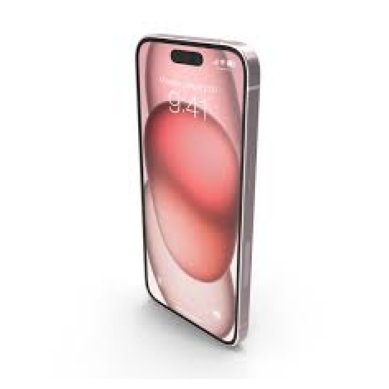

Best Match to the given image from the description: iphone
Confidence score of the description: 0.2711043655872345


In [36]:
unseen_image_description(phone_image, text_descriptions)

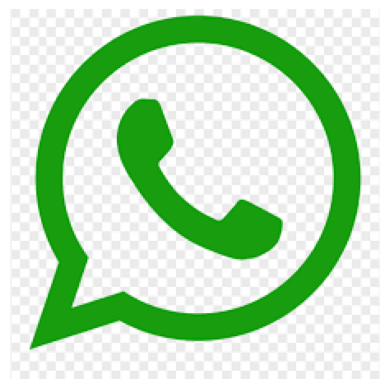

Best Match to the given image from the description: whatsapp icon
Confidence score of the description: 0.3244829773902893


In [37]:
unseen_image_description(whatsapp_image, text_descriptions)

/opt/conda/lib/python3.10/site-packages/PIL/Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


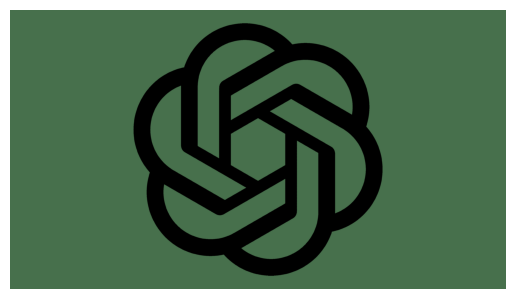

Best Match to the given image from the description: chatgpt icon
Confidence score of the description: 0.26742851734161377


In [38]:
unseen_image_description(chatgpt_image, text_descriptions)

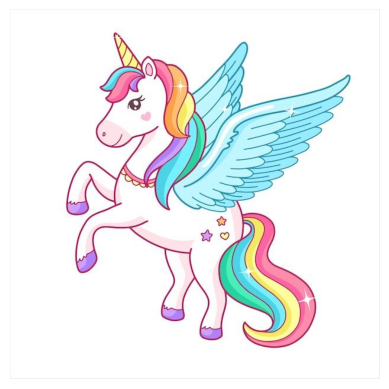

Best Match to the given image from the description: unicorn
Confidence score of the description: 0.28559035062789917


In [39]:
unseen_image_description(unicorn_image, text_descriptions)

In [40]:
new_text_description = ["red car", "wings", "iphone", "google pixel"]

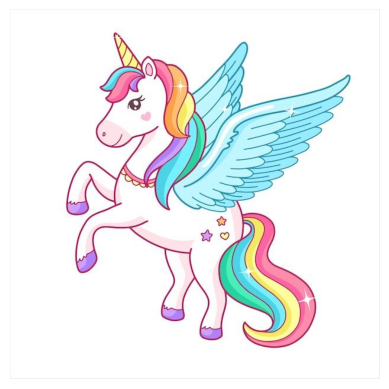

Best Match to the given image from the description: wings
Confidence score of the description: 0.24009530246257782


In [41]:
unseen_image_description(unicorn_image, new_text_description)

In [42]:
new_text_description = ["red car", "wings", "iphone", "google pixel", "horse"]

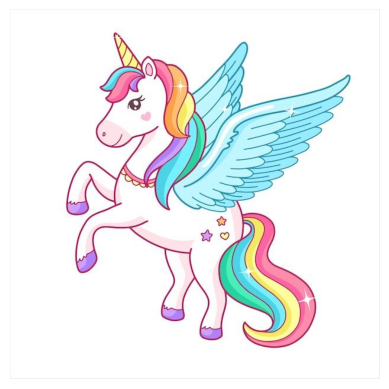

Best Match to the given image from the description: horse
Confidence score of the description: 0.25651493668556213


In [43]:
unseen_image_description(unicorn_image, new_text_description)

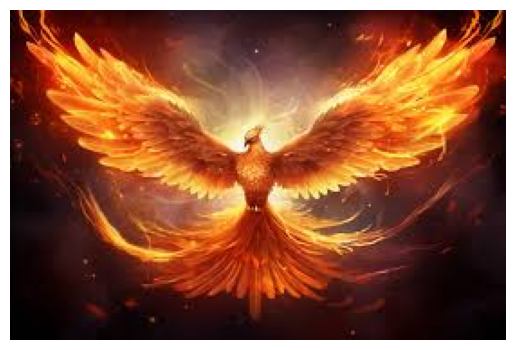

Best Match to the given image from the description: phoenix
Confidence score of the description: 0.28821036219596863


In [44]:
unseen_image_description(phoenix_image, text_descriptions)

In [45]:
new_text_description = ["horse", "fire", "bird", "wings"]

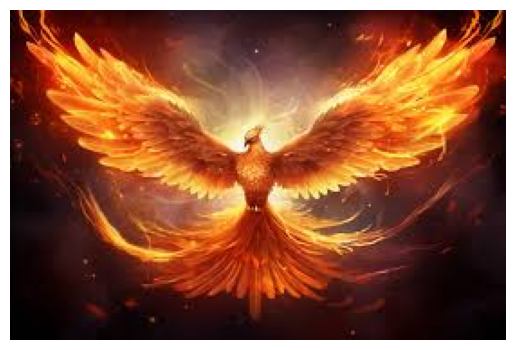

Best Match to the given image from the description: wings
Confidence score of the description: 0.265615314245224


In [46]:
unseen_image_description(phoenix_image, new_text_description)

In [47]:
new_text_description = ["horse", "fire", "bird"]

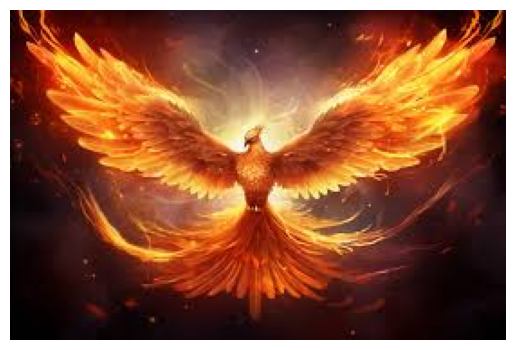

Best Match to the given image from the description: fire
Confidence score of the description: 0.24495869874954224


In [48]:
unseen_image_description(phoenix_image, new_text_description)

In [49]:
new_text_description = ["horse", "fire", "red bird"]

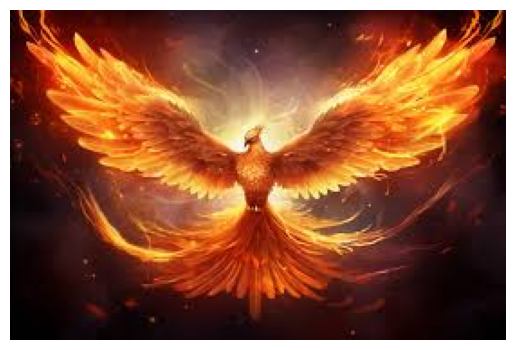

Best Match to the given image from the description: red bird
Confidence score of the description: 0.24756324291229248


In [50]:
unseen_image_description(phoenix_image, new_text_description)

In [51]:
new_text_description = ["sad", "girl", "happy", "proud", "angry"]

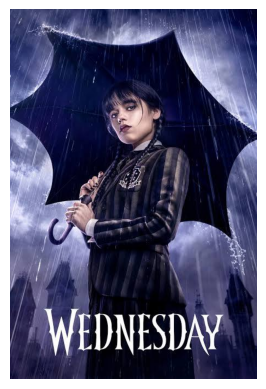

Best Match to the given image from the description: angry
Confidence score of the description: 0.2163180559873581


In [52]:
unseen_image_description(wed_image, new_text_description)

In [29]:
new_text_description = ["sad", "girl", "happy", "proud", "angry", "goth", "rain"]

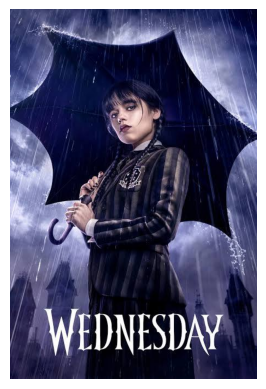

Best Match to the given image from the description: goth
Confidence score of the description: 0.25885552167892456


In [30]:
unseen_image_description(wed_image, new_text_description)

In [27]:
new_text_description = ["happy", "background", "clear sky"]

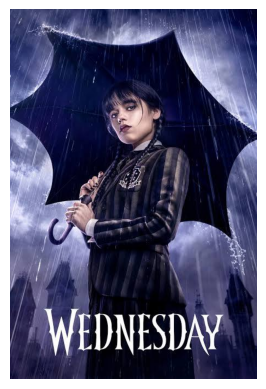

Best Match to the given image from the description: background
Confidence score of the description: 0.2082594931125641


In [28]:
unseen_image_description(wed_image, new_text_description)

# Just For Fun

In [10]:
welcome_image = Image.open("/kaggle/input/welcome/majnu_painting.jpg")

In [15]:
new_text_description = ["painting", "donkey", "friendship"]

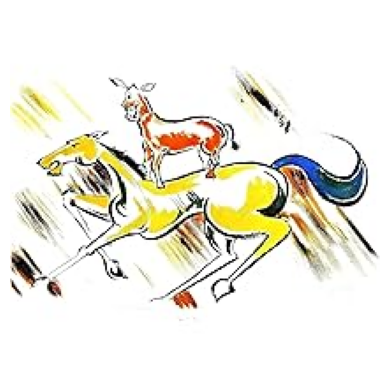

Best Match to the given image from the description: donkey
Confidence score of the description: 0.23198027908802032


In [16]:
unseen_image_description(welcome_image, new_text_description)

In [17]:
new_text_description = ["painting", "donkey", "friendship", "horse"]

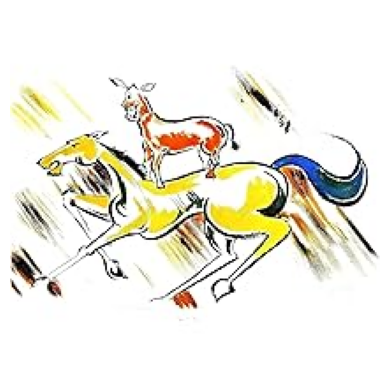

Best Match to the given image from the description: horse
Confidence score of the description: 0.2695508301258087


In [18]:
unseen_image_description(welcome_image, new_text_description)